Nous allons maintenant pouvoir construire nos modèles de machine learning afin de prédire les émissions de CO2 et la consommation d'énergie parmi la base de données des bâtiments non résidentiels dans la ville de Seattle. Les variables à prédire sont nommées respectivement SiteEnergyUse(kBtu) et TotalGHGEmissions.  
Les variables prédictives conservées de la partie précédente sont:  
- Le n° de code du district  
- Le nombre d'étages  
- L'âge du batiment  
- Les différentes superficies du bâtiment et du parking 
- Les ratios des superficies des 1ères, 2nde et 3ème fonctions du logement  
- Les ratios des consommations des différentes sources d'énergies  

Une deuxième sélection des variables prédicitives sera faite pour l'application de nos modèles notamment grâce à la p-value ( partie 1.4). Nous mettrons en oeuvre des modèles linéaires, non linéaires et issus de méthodes ensemblistes.  
  
  
Le notebook se décompose de la manière suivante:

1. Préparation du dataset  
1.1 Imports  
1.2 Transformation des variables catégorielles  
1.3 Standardisation des données  
1.4 Sélection des variables significatives  
1.5 Observations atypiques et influentes  
  
 

2. Fonctions utiles pour l'application des modèles 
  
  

3. Prédiction de la consommation d'énergie  
3.1 Sans l'energy star score  
3.2 Avec l'energy star score  

  
4. Prédiction des émissions de CO2  
4.1 Sans l'energy star score  
4.2 Avec l'energy star score  
4.3 Amélioration


## 1. Préparation du dataset

### 1.1 Imports

In [2]:
#Import des librairies utiles
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from functions import *

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
pd.set_option("display.max_columns",100)

In [5]:
#Import du dataset nettoyé
df=pd.read_pickle('dataset.pkl')

In [6]:
df.reset_index(drop=True,inplace=True)

In [7]:
#On réalise une copie de notre dataset inital
df_init=df.copy()

In [8]:
#On enlève les variables inutiles pour la suite de notre étude
df=df.drop(['Neighborhood','LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA','PrimaryPropertyType',\
           'PropertyName'],axis=1)

In [9]:
df.head()

,CouncilDistrictCode,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Age,propSteamUse,propNaturalGas,propElectricity,HOTEL,OTHER,low_energyuse_co2emi,LARGE_OFFICE,SENIOR_CARE_COMMUNITY,MEDICAL_OFFICE,RETAIL_STORE,HOSPITAL,SUPERMARKET_GROCERY_STORE,PARKING,RESTAURANT,UNIVERSITY,LABORATORY
0,7,12,88434,0,60.0,7226362.5,249.98,89,0.277302,0.176638,0.546060,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,7,11,88502,15064,61.0,8387933.0,295.86,20,0.000000,0.613391,0.386609,0.809918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.145453,0.044629,0.0,0.0
2,7,41,759392,196718,43.0,72587024.0,2089.28,47,0.297113,0.020579,0.682307,0.791220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,7,10,61320,0,56.0,6794584.0,286.43,90,0.325913,0.266567,0.407519,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,7,18,113580,62000,75.0,14172606.0,505.01,36,0.000000,0.621198,0.378802,0.703070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.387339,0.000000,0.0,0.0


### 1.2 Transformation des variables catégorielles

In [10]:
#On applique la fonction get_dummies afin de pouvoir prendre en compte les variables catégorielles sans relation d'ordre.
df=pd.get_dummies(df)

In [11]:
df.head()

,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Age,propSteamUse,propNaturalGas,propElectricity,HOTEL,OTHER,low_energyuse_co2emi,LARGE_OFFICE,SENIOR_CARE_COMMUNITY,MEDICAL_OFFICE,RETAIL_STORE,HOSPITAL,SUPERMARKET_GROCERY_STORE,PARKING,RESTAURANT,UNIVERSITY,LABORATORY,CouncilDistrictCode_1,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7
0,12,88434,0,60.0,7226362.5,249.98,89,0.277302,0.176638,0.546060,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,0,0,0,0,0,1
1,11,88502,15064,61.0,8387933.0,295.86,20,0.000000,0.613391,0.386609,0.809918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.145453,0.044629,0.0,0.0,0,0,0,0,0,0,1
2,41,759392,196718,43.0,72587024.0,2089.28,47,0.297113,0.020579,0.682307,0.791220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,0,0,0,0,0,1
3,10,61320,0,56.0,6794584.0,286.43,90,0.325913,0.266567,0.407519,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,0,0,0,0,0,1
4,18,113580,62000,75.0,14172606.0,505.01,36,0.000000,0.621198,0.378802,0.703070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.387339,0.000000,0.0,0.0,0,0,0,0,0,0,1


In [12]:
#On renomme certaines colonnes pour la suite de notre étude
df.rename(columns={"SiteEnergyUse(kBtu)":'SiteEnergyUse_kBtu','PropertyGFABuilding(s)':'PropertyGFABuildings'},inplace=True)

### 1.3 Standardisation des données

In [13]:
#standardisation de l'ensemble du dataset
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(df)
df_std= pd.DataFrame(std_scale.transform(df),columns=df.columns)

In [14]:
df_std

,NumberofFloors,PropertyGFABuildings,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUse_kBtu,TotalGHGEmissions,Age,propSteamUse,propNaturalGas,propElectricity,HOTEL,OTHER,low_energyuse_co2emi,LARGE_OFFICE,SENIOR_CARE_COMMUNITY,MEDICAL_OFFICE,RETAIL_STORE,HOSPITAL,SUPERMARKET_GROCERY_STORE,PARKING,RESTAURANT,UNIVERSITY,LABORATORY,CouncilDistrictCode_1,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7
0,1.502039,-0.017296,-0.360621,-0.191194,0.163229,0.521250,1.139543,2.938384,-0.341943,-0.621850,4.118190,-0.173743,-1.246419,-0.398483,-0.128056,-0.18806,-0.320145,-0.069822,-0.199907,-0.442547,-0.132030,-0.031099,-0.064842,-0.28549,-0.565821,-0.343090,-0.339561,-0.301034,-0.27547,1.458385
1,1.311102,-0.016672,0.081062,-0.155945,0.292563,0.704222,-1.041128,-0.224148,1.308685,-1.221921,3.284005,-0.173743,-1.246419,-0.398483,-0.128056,-0.18806,-0.320145,-0.069822,-0.199907,0.696805,2.946554,-0.031099,-0.064842,-0.28549,-0.565821,-0.343090,-0.339561,-0.301034,-0.27547,1.458385
2,7.039218,6.138290,5.407237,-0.790420,7.440700,7.856509,-0.187822,3.164327,-0.931740,-0.109101,3.201945,-0.173743,-1.246419,-0.398483,-0.128056,-0.18806,-0.320145,-0.069822,-0.199907,-0.442547,-0.132030,-0.031099,-0.064842,-0.28549,-0.565821,-0.343090,-0.339561,-0.301034,-0.27547,1.458385
3,1.120165,-0.266048,-0.360621,-0.332188,0.115154,0.666615,1.171147,3.492785,-0.002073,-1.143228,4.118190,-0.173743,-1.246419,-0.398483,-0.128056,-0.18806,-0.320145,-0.069822,-0.199907,-0.442547,-0.132030,-0.031099,-0.064842,-0.28549,-0.565821,-0.343090,-0.339561,-0.301034,-0.27547,1.458385
4,2.647662,0.213402,1.457246,0.337535,0.936647,1.538327,-0.535465,-0.224148,1.338192,-1.251303,2.815095,-0.173743,-1.246419,-0.398483,-0.128056,-0.18806,-0.320145,-0.069822,-0.199907,2.591526,-0.132030,-0.031099,-0.064842,-0.28549,-0.565821,-0.343090,-0.339561,-0.301034,-0.27547,1.458385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,-0.407333,-0.599351,-0.360621,-1.988872,-0.149168,0.061904,1.076335,-0.224148,0.917159,-0.832049,-0.270368,-0.173743,0.909259,-0.398483,-0.128056,-0.18806,-0.320145,-0.069822,-0.199907,-0.442547,-0.132030,-0.031099,-0.064842,-0.28549,1.767344,-0.343090,-0.339561,-0.301034,-0.27547,-0.685690
1031,-0.216395,-0.415773,-0.360621,0.408032,-0.493739,-0.438839,-1.641602,-0.224148,-1.009517,1.086491,-0.270368,-0.173743,0.909259,-0.398483,-0.128056,-0.18806,-0.320145,-0.069822,-0.199907,-0.442547,-0.132030,-0.031099,-0.064842,-0.28549,-0.565821,2.914689,-0.339561,-0.301034,-0.27547,-0.685690
1032,-0.598270,-0.703287,-0.360621,0.337535,-0.585409,-0.461730,0.349445,-0.224148,-1.009517,1.086491,-0.270368,-0.173743,0.909259,-0.398483,-0.128056,-0.18806,-0.320145,-0.069822,-0.199907,-0.442547,-0.132030,-0.031099,-0.064842,-0.28549,-0.565821,-0.343090,-0.339561,-0.301034,-0.27547,1.458385
1033,-0.598270,-0.687352,-0.360621,0.972010,-0.598197,-0.444621,0.096613,-0.224148,0.065127,0.016386,-0.270368,-0.173743,0.909259,-0.398483,-0.128056,-0.18806,-0.320145,-0.069822,-0.199907,-0.442547,-0.132030,-0.031099,-0.064842,-0.28549,1.767344,-0.343090,-0.339561,-0.301034,-0.27547,-0.685690


In [15]:
df_std.isna().sum()

NumberofFloors               0
PropertyGFABuildings         0
PropertyGFAParking           0
ENERGYSTARScore              0
SiteEnergyUse_kBtu           0
TotalGHGEmissions            0
Age                          0
propSteamUse                 0
propNaturalGas               0
propElectricity              0
HOTEL                        0
OTHER                        0
low_energyuse_co2emi         0
LARGE_OFFICE                 0
SENIOR_CARE_COMMUNITY        0
MEDICAL_OFFICE               0
RETAIL_STORE                 0
HOSPITAL                     0
SUPERMARKET_GROCERY_STORE    0
PARKING                      0
RESTAURANT                   0
UNIVERSITY                   0
LABORATORY                   0
CouncilDistrictCode_1        0
CouncilDistrictCode_2        0
CouncilDistrictCode_3        0
CouncilDistrictCode_4        0
CouncilDistrictCode_5        0
CouncilDistrictCode_6        0
CouncilDistrictCode_7        0
dtype: int64

In [16]:
df_std.shape

(1035, 30)

### 1.4 Sélection des variables significatives

Nous souhaitons sélectionner les variables les plus significatives pour nos futures prédictions. Pour cela, nous allons appliquer une regression linéaire multiple pour chaque variable à prédire et sélectionner automatiquement un modèle avec les variables les plus utiles avec la fonction backward. les variables apparaissant dans l'une des deux prédictions seront celles qui sont conservées pour l'application de nos modèles de machine learning.

In [17]:
#Regression linéaire des émissions de CO2
reg_multi = smf.ols('TotalGHGEmissions~NumberofFloors+PropertyGFABuildings+PropertyGFAParking+\
Age+propSteamUse+propNaturalGas+propElectricity+HOTEL+OTHER+low_energyuse_co2emi+LARGE_OFFICE+SENIOR_CARE_COMMUNITY+\
MEDICAL_OFFICE+RETAIL_STORE+HOSPITAL+SUPERMARKET_GROCERY_STORE+PARKING+RESTAURANT+UNIVERSITY+LABORATORY+CouncilDistrictCode_1+\
CouncilDistrictCode_2+CouncilDistrictCode_3+CouncilDistrictCode_4+CouncilDistrictCode_5+CouncilDistrictCode_6+CouncilDistrictCode_7', data=df_std).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:      TotalGHGEmissions   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     66.44
Date:                Mon, 08 Nov 2021   Prob (F-statistic):          7.94e-198
Time:                        10:43:30   Log-Likelihood:                -951.95
No. Observations:                1035   AIC:                             1958.
Df Residuals:                    1008   BIC:                             2091.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [18]:
L=list(df_std.columns)
L.remove('SiteEnergyUse_kBtu')
L.remove('ENERGYSTARScore')
L

['NumberofFloors',
 'PropertyGFABuildings',
 'PropertyGFAParking',
 'TotalGHGEmissions',
 'Age',
 'propSteamUse',
 'propNaturalGas',
 'propElectricity',
 'HOTEL',
 'OTHER',
 'low_energyuse_co2emi',
 'LARGE_OFFICE',
 'SENIOR_CARE_COMMUNITY',
 'MEDICAL_OFFICE',
 'RETAIL_STORE',
 'HOSPITAL',
 'SUPERMARKET_GROCERY_STORE',
 'PARKING',
 'RESTAURANT',
 'UNIVERSITY',
 'LABORATORY',
 'CouncilDistrictCode_1',
 'CouncilDistrictCode_2',
 'CouncilDistrictCode_3',
 'CouncilDistrictCode_4',
 'CouncilDistrictCode_5',
 'CouncilDistrictCode_6',
 'CouncilDistrictCode_7']

In [19]:
#Création d'un modèle avec les variables significatives pour les émissions de CO2
columns = L
reg_backward = backward_selected(df_std[columns], 'TotalGHGEmissions')

_______________________________
TotalGHGEmissions ~ LARGE_OFFICE + low_energyuse_co2emi + HOTEL + CouncilDistrictCode_1 + propElectricity + OTHER + propSteamUse + PropertyGFABuildings + MEDICAL_OFFICE + RESTAURANT + PARKING + HOSPITAL + LABORATORY + CouncilDistrictCode_3 + PropertyGFAParking + propNaturalGas + NumberofFloors + SUPERMARKET_GROCERY_STORE + CouncilDistrictCode_5 + CouncilDistrictCode_4 + SENIOR_CARE_COMMUNITY + CouncilDistrictCode_6 + RETAIL_STORE + UNIVERSITY + Age + CouncilDistrictCode_7 + CouncilDistrictCode_2 + 1
remove LARGE_OFFICE (p-value : 0.993 )

_______________________________
TotalGHGEmissions ~ low_energyuse_co2emi + HOTEL + CouncilDistrictCode_1 + propElectricity + OTHER + propSteamUse + PropertyGFABuildings + MEDICAL_OFFICE + RESTAURANT + PARKING + HOSPITAL + LABORATORY + CouncilDistrictCode_3 + PropertyGFAParking + propNaturalGas + NumberofFloors + SUPERMARKET_GROCERY_STORE + CouncilDistrictCode_5 + CouncilDistrictCode_4 + SENIOR_CARE_COMMUNITY + CouncilDi

In [20]:
#Regression linéaire de la consommation d'énergie
reg_multi = smf.ols('SiteEnergyUse_kBtu~NumberofFloors+PropertyGFABuildings+PropertyGFAParking+\
Age+propSteamUse+propNaturalGas+propElectricity+HOTEL+OTHER+low_energyuse_co2emi+LARGE_OFFICE+SENIOR_CARE_COMMUNITY+\
MEDICAL_OFFICE+RETAIL_STORE+HOSPITAL+SUPERMARKET_GROCERY_STORE+PARKING+RESTAURANT+UNIVERSITY+LABORATORY+CouncilDistrictCode_1+\
CouncilDistrictCode_2+CouncilDistrictCode_3+CouncilDistrictCode_4+CouncilDistrictCode_5+CouncilDistrictCode_6+CouncilDistrictCode_7', data=df_std).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:     SiteEnergyUse_kBtu   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     115.5
Date:                Mon, 08 Nov 2021   Prob (F-statistic):          1.05e-280
Time:                        10:43:31   Log-Likelihood:                -753.91
No. Observations:                1035   AIC:                             1562.
Df Residuals:                    1008   BIC:                             1695.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [21]:
L=list(df_std.columns)
L.remove('TotalGHGEmissions')
L.remove('ENERGYSTARScore')
L

['NumberofFloors',
 'PropertyGFABuildings',
 'PropertyGFAParking',
 'SiteEnergyUse_kBtu',
 'Age',
 'propSteamUse',
 'propNaturalGas',
 'propElectricity',
 'HOTEL',
 'OTHER',
 'low_energyuse_co2emi',
 'LARGE_OFFICE',
 'SENIOR_CARE_COMMUNITY',
 'MEDICAL_OFFICE',
 'RETAIL_STORE',
 'HOSPITAL',
 'SUPERMARKET_GROCERY_STORE',
 'PARKING',
 'RESTAURANT',
 'UNIVERSITY',
 'LABORATORY',
 'CouncilDistrictCode_1',
 'CouncilDistrictCode_2',
 'CouncilDistrictCode_3',
 'CouncilDistrictCode_4',
 'CouncilDistrictCode_5',
 'CouncilDistrictCode_6',
 'CouncilDistrictCode_7']

In [22]:
#Création d'un modèle avec les variables significatives pour la consommation d'énergie
columns = L
reg_backward = backward_selected(df_std[columns], 'SiteEnergyUse_kBtu')

_______________________________
SiteEnergyUse_kBtu ~ LARGE_OFFICE + low_energyuse_co2emi + HOTEL + CouncilDistrictCode_1 + propElectricity + OTHER + propSteamUse + PropertyGFABuildings + MEDICAL_OFFICE + RESTAURANT + PARKING + HOSPITAL + LABORATORY + CouncilDistrictCode_3 + PropertyGFAParking + propNaturalGas + NumberofFloors + SUPERMARKET_GROCERY_STORE + CouncilDistrictCode_5 + CouncilDistrictCode_4 + SENIOR_CARE_COMMUNITY + CouncilDistrictCode_6 + RETAIL_STORE + UNIVERSITY + Age + CouncilDistrictCode_7 + CouncilDistrictCode_2 + 1
remove UNIVERSITY (p-value : 0.941 )

_______________________________
SiteEnergyUse_kBtu ~ LARGE_OFFICE + low_energyuse_co2emi + HOTEL + CouncilDistrictCode_1 + propElectricity + OTHER + propSteamUse + PropertyGFABuildings + MEDICAL_OFFICE + RESTAURANT + PARKING + HOSPITAL + LABORATORY + CouncilDistrictCode_3 + PropertyGFAParking + propNaturalGas + NumberofFloors + SUPERMARKET_GROCERY_STORE + CouncilDistrictCode_5 + CouncilDistrictCode_4 + SENIOR_CARE_COMMUN

On sélectionne les variables les plus utiles sur l'un au moins des deux modèles. 

In [23]:
df_std=df_std[['propSteamUse','propNaturalGas','propElectricity','LARGE_OFFICE','MEDICAL_OFFICE','HOSPITAL','RETAIL_STORE',\
               'PARKING','SUPERMARKET_GROCERY_STORE', 'low_energyuse_co2emi',\
               'OTHER','LABORATORY','HOTEL','SENIOR_CARE_COMMUNITY','PropertyGFAParking','PropertyGFABuildings',\
               'SiteEnergyUse_kBtu','ENERGYSTARScore','TotalGHGEmissions']]

In [24]:
df_std

,propSteamUse,propNaturalGas,propElectricity,LARGE_OFFICE,MEDICAL_OFFICE,HOSPITAL,RETAIL_STORE,PARKING,SUPERMARKET_GROCERY_STORE,low_energyuse_co2emi,OTHER,LABORATORY,HOTEL,SENIOR_CARE_COMMUNITY,PropertyGFAParking,PropertyGFABuildings,SiteEnergyUse_kBtu,ENERGYSTARScore,TotalGHGEmissions
0,2.938384,-0.341943,-0.621850,-0.398483,-0.18806,-0.069822,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.118190,-0.128056,-0.360621,-0.017296,0.163229,-0.191194,0.521250
1,-0.224148,1.308685,-1.221921,-0.398483,-0.18806,-0.069822,-0.320145,0.696805,-0.199907,-1.246419,-0.173743,-0.064842,3.284005,-0.128056,0.081062,-0.016672,0.292563,-0.155945,0.704222
2,3.164327,-0.931740,-0.109101,-0.398483,-0.18806,-0.069822,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,3.201945,-0.128056,5.407237,6.138290,7.440700,-0.790420,7.856509
3,3.492785,-0.002073,-1.143228,-0.398483,-0.18806,-0.069822,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.118190,-0.128056,-0.360621,-0.266048,0.115154,-0.332188,0.666615
4,-0.224148,1.338192,-1.251303,-0.398483,-0.18806,-0.069822,-0.320145,2.591526,-0.199907,-1.246419,-0.173743,-0.064842,2.815095,-0.128056,1.457246,0.213402,0.936647,0.337535,1.538327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,-0.224148,0.917159,-0.832049,-0.398483,-0.18806,-0.069822,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.599351,-0.149168,-1.988872,0.061904
1031,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.069822,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.415773,-0.493739,0.408032,-0.438839
1032,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.069822,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.703287,-0.585409,0.337535,-0.461730
1033,-0.224148,0.065127,0.016386,-0.398483,-0.18806,-0.069822,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.687352,-0.598197,0.972010,-0.444621


### 1.5  Observations atypiques et influentes

Nous allons identifier puis enlever les observations atypiques et influentes dans le dernier modèle de régression multiple créé pour la consommation d'énergie.  
Ressource : https://openclassrooms.com/fr/courses/4525326-realisez-des-modelisations-de-donnees-performantes/5754143-analysez-les-resultats

In [25]:
#valeurs atypiques sur les variables explicatives

In [26]:
alpha = 0.05 #niveaux de tests
n = df_std.shape[0] #Nombres d'observation
p = 16    #Nombre de variables 

In [27]:
reg_backward.get_influence()


In [28]:
df_init['levier']=reg_backward.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

On considère comme valeur atypique l'observation i si h_ii>2*p/n , où h_ii est élément diagonal de la matrice H de projection sur X. 

In [29]:
#Valeurs atypiques sur les variables prédicitives
df_init.loc[df_init['levier'] > seuil_levier, :]

,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Age,propSteamUse,propNaturalGas,propElectricity,HOTEL,OTHER,low_energyuse_co2emi,LARGE_OFFICE,SENIOR_CARE_COMMUNITY,MEDICAL_OFFICE,RETAIL_STORE,HOSPITAL,SUPERMARKET_GROCERY_STORE,PARKING,RESTAURANT,UNIVERSITY,LABORATORY,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,levier
2,HOTEL,5673-The Westin Seattle,7,DOWNTOWN,41,759392,196718,43.0,72587024.0,2089.28,47,0.297113,0.020579,0.682307,0.791220,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,756493.0,0.0,0.000000,0.093719
11,HOTEL,Hotel Vintage Seattle,7,DOWNTOWN,11,66990,25200,35.0,10750010.0,511.39,94,0.453102,0.190399,0.356499,0.730990,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.273349,0.0,0.0,0.0,67390.0,25200.0,0.000000,0.034376
14,OTHER,King County Courthouse,7,DOWNTOWN,10,540360,0,76.0,44984468.0,1265.29,100,0.000000,0.458528,0.541472,0.000000,0.99406,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,537150.0,0.0,0.000000,0.160595
26,HOTEL,Seattle Hilton Hotel,7,DOWNTOWN,24,126240,205970,67.0,16163194.0,295.33,47,0.000000,0.244926,0.755074,1.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,348630.0,0.0,0.000000,0.072116
39,SENIOR_CARE_COMMUNITY,PSSA - The Mount,1,SOUTHWEST,5,217603,0,54.0,42792072.0,1727.11,94,0.000000,0.723669,0.276331,0.000000,0.00000,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,296313.0,0.0,0.000000,0.067949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,HOSPITAL,Seattle Children's Hospital Building Hope,4,NORTHEAST,8,330000,0,58.0,57764408.0,1789.69,3,0.000000,0.520413,0.479587,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.731818,0.0,0.000000,0.0,0.0,0.0,241500.0,0.0,0.000000,0.149696
1019,HOTEL,Hotel Ballard,6,BALLARD,4,39433,22948,62.0,3497215.5,24.38,3,0.000000,0.000000,1.000000,0.965759,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.417868,0.0,0.0,0.0,60245.0,26067.0,0.000000,0.032784
1020,SENIOR_CARE_COMMUNITY,Aegis on Madison,3,CENTRAL,6,79805,0,25.0,7531325.0,184.81,3,0.000000,0.380765,0.619235,0.000000,0.00000,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.087714,0.0,0.0,0.0,79805.0,7000.0,0.000000,0.067306
1022,SUPERMARKET_GROCERY_STORE,70500891 -- Ballard,6,BALLARD,8,41198,0,44.0,7768057.5,82.58,6,0.000000,0.079324,0.920676,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.0,41198.0,0.0,0.000000,0.031754


In [30]:
#valeurs atypiques de la variable à prédire

On détermine les valeurs atypiques à partir des résidus studentisés internes. 

In [31]:
df_init['rstudent'] = reg_backward.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

In [32]:
df_init.loc[df_init['rstudent'] > seuil_rstudent, :]

,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Age,propSteamUse,propNaturalGas,propElectricity,HOTEL,OTHER,low_energyuse_co2emi,LARGE_OFFICE,SENIOR_CARE_COMMUNITY,MEDICAL_OFFICE,RETAIL_STORE,HOSPITAL,SUPERMARKET_GROCERY_STORE,PARKING,RESTAURANT,UNIVERSITY,LABORATORY,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,levier,rstudent
2,HOTEL,5673-The Westin Seattle,7,DOWNTOWN,41,759392,196718,43.0,72587024.0,2089.28,47,0.297113,0.020579,0.682307,0.791220,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,756493.0,0.0,0.0,0.093719,4.978064
12,HOTEL,Renaissance Seattle Hotel,7,DOWNTOWN,28,331281,85000,31.0,33556756.0,802.89,33,0.000000,0.367481,0.632519,0.836764,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.204189,0.000000,0.0,0.0,348329.0,85000.0,0.0,0.021572,2.135950
14,OTHER,King County Courthouse,7,DOWNTOWN,10,540360,0,76.0,44984468.0,1265.29,100,0.000000,0.458528,0.541472,0.000000,0.994060,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,537150.0,0.0,0.0,0.160595,2.922733
39,SENIOR_CARE_COMMUNITY,PSSA - The Mount,1,SOUTHWEST,5,217603,0,54.0,42792072.0,1727.11,94,0.000000,0.723669,0.276331,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,296313.0,0.0,0.0,0.067949,5.746913
112,MEDICAL_OFFICE,BMR-201 Elliott Avenue LLC,7,MAGNOLIA_QUEEN_ANNE,5,151000,39000,1.0,28731502.0,661.04,89,0.000000,0.347565,0.652435,0.000000,0.000000,0.051605,0.000000,0.0,0.772321,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,146741.0,9805.0,0.0,0.027524,3.514063
113,HOTEL,Edgewater Seattle,7,DOWNTOWN,4,122309,0,8.0,25453690.0,1060.13,55,0.000000,0.751606,0.248394,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,122309.0,0.0,0.0,0.020328,3.328948
114,HOTEL,337v2-Seattle Waterfront Marriott,7,DOWNTOWN,8,215473,38800,29.0,26659244.0,780.84,13,0.000000,0.483723,0.516277,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,277000.0,0.0,0.0,0.020629,2.302016
158,LARGE_OFFICE,3101 Western Avenue,7,DOWNTOWN,8,191117,61986,3.0,29949248.0,208.79,32,0.000000,0.000000,1.000000,0.000000,0.086060,0.000000,0.626942,0.0,0.000000,0.000000,0.000000,0.0,0.277318,0.000000,0.0,0.0,158681.0,70190.0,21782.0,0.007188,3.989099
165,HOTEL,Fairmont Olympic Seattle,7,DOWNTOWN,12,542305,0,45.0,56485204.0,2573.75,93,0.503475,0.070252,0.426273,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,542305.0,0.0,0.0,0.064017,4.729511
173,HOTEL,WAC aggregate,7,DOWNTOWN,21,305548,0,58.0,33729336.0,1510.85,86,0.482801,0.084991,0.432207,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,310000.0,0.0,0.0,0.043441,2.472696


In [33]:
#observations influentes sur le modele de regression linéaire

On utilise la disance de cook.

In [34]:
influence = reg_backward.get_influence().summary_frame()

In [35]:
df_init['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

In [36]:
df_init.loc[df_init['dcooks'] > seuil_dcook, :]

,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Age,propSteamUse,propNaturalGas,propElectricity,HOTEL,OTHER,low_energyuse_co2emi,LARGE_OFFICE,SENIOR_CARE_COMMUNITY,MEDICAL_OFFICE,RETAIL_STORE,HOSPITAL,SUPERMARKET_GROCERY_STORE,PARKING,RESTAURANT,UNIVERSITY,LABORATORY,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,levier,rstudent,dcooks
2,HOTEL,5673-The Westin Seattle,7,DOWNTOWN,41,759392,196718,43.0,72587024.0,2089.28,47,0.297113,0.020579,0.682307,0.791220,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,756493.0,0.0,0.000000,0.093719,4.978064,0.160165
12,HOTEL,Renaissance Seattle Hotel,7,DOWNTOWN,28,331281,85000,31.0,33556756.0,802.89,33,0.000000,0.367481,0.632519,0.836764,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.204189,0.0,0.0,0.0,348329.0,85000.0,0.000000,0.021572,2.135950,0.006287
14,OTHER,King County Courthouse,7,DOWNTOWN,10,540360,0,76.0,44984468.0,1265.29,100,0.000000,0.458528,0.541472,0.000000,0.99406,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,537150.0,0.0,0.000000,0.160595,2.922733,0.102146
39,SENIOR_CARE_COMMUNITY,PSSA - The Mount,1,SOUTHWEST,5,217603,0,54.0,42792072.0,1727.11,94,0.000000,0.723669,0.276331,0.000000,0.00000,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,296313.0,0.0,0.000000,0.067949,5.746913,0.150484
40,SENIOR_CARE_COMMUNITY,Foss Home and Village,5,NORTHWEST,2,93397,0,1.0,16402563.0,609.10,46,0.000000,0.653743,0.346257,0.000000,0.00000,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,93397.0,0.0,0.000000,0.067039,1.301771,0.007611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,HOSPITAL,Seattle Children's Hospital Building Hope,4,NORTHEAST,8,330000,0,58.0,57764408.0,1789.69,3,0.000000,0.520413,0.479587,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.731818,0.0,0.000000,0.0,0.0,0.0,241500.0,0.0,0.000000,0.149696,1.955502,0.042076
1023,LARGE_OFFICE,Amazon Phase VI,7,LAKE_UNION,6,427181,0,99.0,16371039.0,213.70,2,0.000000,0.131818,0.868182,0.000000,0.00000,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.396073,0.0,0.0,0.0,427181.0,169195.0,0.000000,0.029323,-1.713242,0.005542
1025,LARGE_OFFICE,"MAPS 325 Ninth Avenue North, LLC",7,LAKE_UNION,12,317442,163260,99.0,12720069.0,147.14,2,0.000000,0.099614,0.900386,0.000000,0.00000,0.0,0.711245,0.0,0.0,0.000000,0.000000,0.0,0.284155,0.0,0.0,0.0,341897.0,136594.0,0.000000,0.022083,-2.082718,0.006122
1026,LARGE_OFFICE,"Sidneysea, LLC",7,LAKE_UNION,12,317189,166208,98.0,13998638.0,202.12,1,0.000000,0.161846,0.838154,0.000000,0.00000,0.0,0.707851,0.0,0.0,0.000000,0.000000,0.0,0.305333,0.0,0.0,0.0,342173.0,147597.0,0.000000,0.023256,-1.873707,0.005224


On détermine les observations atypiques et influentes puis on les supprime

In [37]:
#ensemble des valeurs atypiques et influentes au modèle de regression linéaire mutiple de la consommation d'énergie.
dh=df_init.loc[(df_init['dcooks'] > seuil_dcook)&((df_init['rstudent'] > seuil_rstudent)|(df_init['levier'] > seuil_levier)), :]

In [38]:
#Nombre de valeurs atypiques et influentes
dh.shape[0]

57

In [39]:
#suppression des valeurs atypiques et influentes
df_after=df_init.drop(list(dh.index))

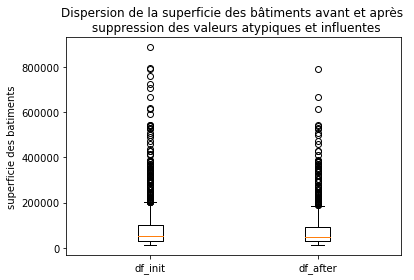

In [40]:
#Dispersion de la superficie des bâtiments avant et après suppression des valeurs atypiques et influentes

import pylab

BoxName = ['df_init','df_after']

data = [df_init['PropertyGFABuilding(s)'],df_after['PropertyGFABuilding(s)']]

plt.boxplot(data)

#plt.ylim(0,30)
plt.ylabel('superficie des batiments')
plt.title('Dispersion de la superficie des bâtiments avant et après \n suppression des valeurs atypiques et influentes')

pylab.xticks([1,2],BoxName)

plt.show()

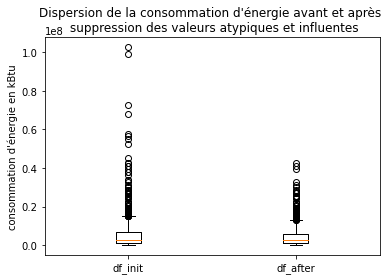

In [41]:
#Dispersion de la consomation d'énergie avant et après suppression des valeurs atypiques et influentes
data = [df_init['SiteEnergyUse(kBtu)'],df_after['SiteEnergyUse(kBtu)']]

plt.boxplot(data)
plt.title('Dispersion de la consommation d\'énergie avant et après \n suppression des valeurs atypiques et influentes')

pylab.xticks([1,2],BoxName)
plt.ylabel('consommation d\'énergie en kBtu')
plt.show()

On constate que des valeurs extremes ont été supprimées.

In [42]:
#répartition par type de propriétés avant suppression
df_init.PrimaryPropertyType.value_counts()

SMALL_AND_MID_SIZED_OFFICE    235
LARGE_OFFICE                  148
WAREHOUSE                     143
K_12_SCHOOL                   125
RETAIL_STORE                   77
HOTEL                          71
WORSHIP_FACILITY               65
DISTRIBUTION_CENTER            40
SUPERMARKET_GROCERY_STORE      38
MEDICAL_OFFICE                 36
MIXED_USE_PROPERTY             19
SENIOR_CARE_COMMUNITY          17
OTHER                           8
REFRIGERATED_WAREHOUSE          5
HOSPITAL                        5
OFFICE                          3
Name: PrimaryPropertyType, dtype: int64

In [43]:
#répartition par type de propriétés après suppression
df_after.PrimaryPropertyType.value_counts()

SMALL_AND_MID_SIZED_OFFICE    234
WAREHOUSE                     143
LARGE_OFFICE                  128
K_12_SCHOOL                   125
RETAIL_STORE                   76
WORSHIP_FACILITY               64
HOTEL                          63
DISTRIBUTION_CENTER            40
SUPERMARKET_GROCERY_STORE      36
MEDICAL_OFFICE                 28
MIXED_USE_PROPERTY             17
SENIOR_CARE_COMMUNITY           9
OTHER                           6
REFRIGERATED_WAREHOUSE          5
OFFICE                          3
HOSPITAL                        1
Name: PrimaryPropertyType, dtype: int64

Nous constatons que nous avons supprimé la quasi-totalité des hopitaux. Avec davantage de données il serait plus apprororié de faire un modèle spécifique pour ces bâtiments.

Les observations atypiques et influentes correspondent à des bâtiments qui ont une grande consommation d'énergie. On supprime ces outliers du dataset.

In [44]:
df_std=df_std.drop(list(dh.index))

In [45]:
df_std.shape

(978, 19)

In [46]:
df_std['HOSPITAL'].value_counts()

-0.069822    977
 9.920243      1
Name: HOSPITAL, dtype: int64

In [47]:
#On décide de supprimer l'hopital restant ainsi que la variable hopital.

In [48]:
df_std=df_std[df_std['HOSPITAL']<0]

In [49]:
df_std=df_std.drop('HOSPITAL',axis=1)

In [50]:
df_std.shape

(977, 18)

## 2. Fonctions utiles pour l'application des modèles

In [51]:
def prepare_resume():
    '''Fonction qui prépare un dataframe avec l'ensemble des éléments d'évaluation du modèle à compléter
    '''
    dg=pd.DataFrame(index=['Type du modèle','Meilleurs hyperparamètres',\
                           'RMSE','R²','meilleur score gridsearchCV','Temps d\'exécution entrainement (sec)',\
                           'Temps d\'exécution prédiction (sec)',\
                           'moyenne pour 20 splits','ecart-type(R²) pour 20 split'], columns=[])
    return dg

In [52]:
def regressions_naives(dg,X_train,y_train,X_test,y_test):
    
    '''fonction qui calcule le R2 et la RMSE obtenus avec les regressions naïves et conserve le moins pire modèle 
    dans dg
    '''
    from sklearn import dummy
    from sklearn import metrics
    
    #regression avec la médiane
    dum = dummy.DummyRegressor(strategy='median')
    dum.fit(X_train, y_train)
    y_pred = dum.predict(X_test)
    dg.loc['RMSE','reg mediane']=np.round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3)
    dg.loc['R²','reg mediane']=np.round(metrics.r2_score(y_pred,y_test), 3)
    
    #regression avec la moyenne
    dum = dummy.DummyRegressor(strategy='mean')
    dum.fit(X_train, y_train)
    y_pred = dum.predict(X_test)
    dg.loc['RMSE','reg moyenne']=np.round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3)
    dg.loc['R²','reg moyenne']=np.round(metrics.r2_score(y_pred,y_test), 3)
    
    #regression aléatoire
    y_pred = np.random.randint(np.min(y_train), np.max(y_train), y_test.shape)
    dg.loc['RMSE','reg aleatoire']=np.round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3)
    dg.loc['R²','reg aleatoire']=np.round(metrics.r2_score(y_pred,y_test), 3)
    
    m=dg.loc['R²',:].max()
    
    if dg.loc['R²','reg mediane']==m:
        dg=dg[['reg mediane']]
    elif dg.loc['R²','reg moyenne']==m:
        dg=dg[['reg moyenne']]
    else:
        dg=dg[['reg aleatoire']]

    return dg

In [53]:
def apply_models(dg,X_train,y_train,X_test,y_test,param_grid_models,call_models,type_model,columns_model):
    '''Fonction qui calcule les meilleurs hyperparamètres et les scores des modèles et les répertorie dans dg
       param_grid_model est un dictionnaire qui associe les hyperparamètres à tester pour chaque modèle
       call_models est un dictionnaire qui contient les commandes associées au modèle
       type_model est un dictionnaire qui contient le type de chaque modèle 
       columns_model est un dictionnaire contenant le nom de la colonne associée au modèle dans dg'''
    for key in params_grid_models:
        
        #Pour chaque modèle
        
        #On met dans dg le type du modèle
        dg.loc['Type du modèle',columns_model[key]]=type_model[key]
        
        #on réalise un grid search CV
        param_grid=params_grid_models[key]
        locals()[key] = model_selection.GridSearchCV(call_models[key],param_grid,cv=5,scoring=score)
        locals()[key].fit(X_train,y_train)
        
        #On conserve le score du meilleur modèle et on le stocke dans dg
        dg.loc['meilleur score gridsearchCV',columns_model[key]]=locals()[key].best_score_
        
        #On effectue la  prédiction sur le jeu de test avec le meilleur modèle
        y_pred=locals()[key].predict(X_test)
        
        #On relève les hyperparamètres du meilleur modèle et on les met dans dg
        bestparam={}
        for k,v in locals()[key].best_params_.items():
            if (type(v) in [int, float, np.float64]): #On se limite à 3 chiffres après la virgule pour les hyperparamètres numériques
                bestparam[k]=np.round(v,3)
            else :
                bestparam[k]=v
                
        dg.loc['Meilleurs hyperparamètres',columns_model[key]]=str(bestparam)
        
        
        #On calcule les scores de prédiction et on les met dans dg
        dg.loc['R²',columns_model[key]]=np.round(metrics.r2_score(y_pred,y_test),3)
        dg.loc['RMSE',columns_model[key]]=np.round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3)
        
        #On met dans dg le type du modèle
        dg.loc['Type du modèle',columns_model[key]]=type_model[key]
    
        
        
    return dg


In [54]:
import timeit
def check_split(dg,data,var_tostratify,best_param_model):
    '''Fonction qui réalise 20 train_test_split sur le dataset. 
    Pour chaque split, la fonction:
     - applique le modèle donné sur le jeu d'entrainement
     - réalise la prédiction sur le jeu de test et calcule le r2
     La fonction retourne dg complété de la moyenne et de l'écart type des 20 r2
     '''
    
    for key in best_param_model:
        scores_test=[]
        
        for s in range(20):
        
            train2,test2=train_test_split(data,test_size=0.2,random_state=s,stratify=data[var_tostratify])
            X_train2=train2.iloc[:,:-2]
            y_train2=train2.iloc[:,-1]
            X_test2=test2.iloc[:,:-2]
            y_test2=test2.iloc[:,-1]
        
            start_time = timeit.default_timer()
            reg = best_param_model[key]
            reg.fit(X_train2, y_train2)
            elapsed = timeit.default_timer() - start_time
            
            if s==0:
                 dg.loc['Temps d\'exécution entrainement (sec)',columns_model[key]]=np.round(elapsed,3)
        
            start_time_test=timeit.default_timer()
            y_pred=reg.predict(X_test2)
            elapsed = timeit.default_timer() - start_time_test
            
            if s==0:
                dg.loc['Temps d\'exécution prédiction (sec)',columns_model[key]]=np.round(elapsed,3)
        
            scores_test.append(metrics.r2_score(y_pred,y_test2))
            
        
        dg.loc['moyenne pour 20 splits',columns_model[key]]=np.round(np.mean(scores_test),3)
        dg.loc['ecart-type(R²) pour 20 split',columns_model[key]]=np.round(np.std(scores_test),3)
        
    #Pour les régréssions SVR et Ridge à noyaux polynomial et gaussien, on garde la regression la plus performante
    if dg.loc['meilleur score gridsearchCV','SVR noyau polynomial']>dg.loc['meilleur score gridsearchCV','SVR noyau gaussien']:
        dg.drop('SVR noyau gaussien',axis=1,inplace=True)
    else:
        dg.drop('SVR noyau polynomial',axis=1,inplace=True)
            
    if dg.loc['meilleur score gridsearchCV','RIDGE noyau polynomial']>dg.loc['meilleur score gridsearchCV','RIDGE noyau gaussien']:
        dg.drop('RIDGE noyau gaussien',axis=1,inplace=True)
    else:
        dg.drop('RIDGE noyau polynomial',axis=1,inplace=True)
        
    return dg

## 3. Prédiction de la consommation d'énergie

### 3.1 Sans energy star score

In [55]:
#On réalise une copie de df_std
df1_std=df_std.copy()

 On crée des groupes pour la consommation d'énergie afin d'équilibrer le train_test_split.

In [56]:
k=df1_std['SiteEnergyUse_kBtu'].describe(percentiles=np.arange(0,1,0.05))

In [57]:
df1_std['SiteEnergyUse_group']=pd.cut(df1_std['SiteEnergyUse_kBtu'],bins=[-1]+list(k.values[5:]))

In [58]:
df1_std

,propSteamUse,propNaturalGas,propElectricity,LARGE_OFFICE,MEDICAL_OFFICE,RETAIL_STORE,PARKING,SUPERMARKET_GROCERY_STORE,low_energyuse_co2emi,OTHER,LABORATORY,HOTEL,SENIOR_CARE_COMMUNITY,PropertyGFAParking,PropertyGFABuildings,SiteEnergyUse_kBtu,ENERGYSTARScore,TotalGHGEmissions,SiteEnergyUse_group
0,2.938384,-0.341943,-0.621850,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.118190,-0.128056,-0.360621,-0.017296,0.163229,-0.191194,0.521250,"(0.158, 0.326]"
1,-0.224148,1.308685,-1.221921,-0.398483,-0.18806,-0.320145,0.696805,-0.199907,-1.246419,-0.173743,-0.064842,3.284005,-0.128056,0.081062,-0.016672,0.292563,-0.155945,0.704222,"(0.158, 0.326]"
3,3.492785,-0.002073,-1.143228,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.118190,-0.128056,-0.360621,-0.266048,0.115154,-0.332188,0.666615,"(0.00749, 0.158]"
4,-0.224148,1.338192,-1.251303,-0.398483,-0.18806,-0.320145,2.591526,-0.199907,-1.246419,-0.173743,-0.064842,2.815095,-0.128056,1.457246,0.213402,0.936647,0.337535,1.538327,"(0.654, 1.102]"
5,-0.224148,0.924891,-0.839747,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.030639,-0.128056,-0.360621,-0.067076,-0.000174,-1.354397,0.226771,"(-0.1, 0.00749]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,-0.224148,0.917159,-0.832049,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.599351,-0.149168,-1.988872,0.061904,"(-0.208, -0.1]"
1031,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.415773,-0.493739,0.408032,-0.438839,"(-0.506, -0.486]"
1032,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.703287,-0.585409,0.337535,-0.461730,"(-0.593, -0.568]"
1033,-0.224148,0.065127,0.016386,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.687352,-0.598197,0.972010,-0.444621,"(-1.0, -0.593]"


On ordonne et on sélectionne les colonnes de notre dataset.

In [59]:
L=df1_std.columns.tolist()

In [60]:
L

['propSteamUse',
 'propNaturalGas',
 'propElectricity',
 'LARGE_OFFICE',
 'MEDICAL_OFFICE',
 'RETAIL_STORE',
 'PARKING',
 'SUPERMARKET_GROCERY_STORE',
 'low_energyuse_co2emi',
 'OTHER',
 'LABORATORY',
 'HOTEL',
 'SENIOR_CARE_COMMUNITY',
 'PropertyGFAParking',
 'PropertyGFABuildings',
 'SiteEnergyUse_kBtu',
 'ENERGYSTARScore',
 'TotalGHGEmissions',
 'SiteEnergyUse_group']

In [61]:
L.remove('SiteEnergyUse_kBtu')
L.append('SiteEnergyUse_kBtu')
L.remove('TotalGHGEmissions')
L.remove('ENERGYSTARScore')

In [62]:
df1_std=df1_std.loc[:,L]

In [63]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df1_std,test_size=0.2,random_state=0,stratify=df1_std['SiteEnergyUse_group'])

On définit nos X_train,y_train,X_test,y_test

In [64]:
train.head()

,propSteamUse,propNaturalGas,propElectricity,LARGE_OFFICE,MEDICAL_OFFICE,RETAIL_STORE,PARKING,SUPERMARKET_GROCERY_STORE,low_energyuse_co2emi,OTHER,LABORATORY,HOTEL,SENIOR_CARE_COMMUNITY,PropertyGFAParking,PropertyGFABuildings,SiteEnergyUse_group,SiteEnergyUse_kBtu
404,-0.224148,1.072982,-0.987213,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.325131,"(-0.377, -0.333]",-0.333670
685,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.610526,"(-1.0, -0.593]",-0.630149
7,3.504980,0.073987,-1.222991,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,3.565791,-0.128056,0.204647,0.399677,"(1.102, 3.907]",1.141968
687,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.029209,-0.173743,-0.064842,-0.270368,-0.128056,-0.042524,-0.555939,"(-0.506, -0.486]",-0.498099
424,-0.224148,0.085557,-0.003958,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.182745,"(0.654, 1.102]",0.913281


In [65]:
X_train=train.iloc[:,:-2]

In [66]:
y_train=train.iloc[:,-1]

In [67]:
y_train

404   -0.333670
685   -0.630149
7      1.141968
687   -0.498099
424    0.913281
         ...   
317   -0.203868
516   -0.613696
862   -0.356769
892   -0.478171
646   -0.563367
Name: SiteEnergyUse_kBtu, Length: 781, dtype: float64

In [68]:
X_test=test.iloc[:,:-2]

In [69]:
y_test=test.iloc[:,-1]

In [70]:
dg=prepare_resume()

In [71]:
dg

""
Type du modèle
Meilleurs hyperparamètres
RMSE
R²
meilleur score gridsearchCV
Temps d'exécution entrainement (sec)
Temps d'exécution prédiction (sec)
moyenne pour 20 splits
ecart-type(R²) pour 20 split


In [72]:
#retourne la meilleure regression naive 
dg=regressions_naives(dg,X_train,y_train,X_test,y_test)

In [73]:
dg

,reg moyenne
Type du modèle,NaN
Meilleurs hyperparamètres,NaN
RMSE,0.673
R²,0.000
meilleur score gridsearchCV,NaN
Temps d'exécution entrainement (sec),NaN
Temps d'exécution prédiction (sec),NaN
moyenne pour 20 splits,NaN
ecart-type(R²) pour 20 split,NaN


Nous allons maintenant créer des modèles plus performants.

In [74]:
from sklearn import model_selection
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn import kernel_ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

In [75]:
score='r2'

In [76]:
#Pour chaque modèle, on définit les paramètres à tester dans le gridsearchCV
params_grid_models={'reg_lin_ridge': {'alpha':np.logspace(-5, 5, 10)}, 
                    
                    'reg_lin_lasso':{'alpha':np.logspace(-5, 5, 10)},

                    'reg_lin_svr':{'C':[1,10,100],'epsilon':np.arange(0.1,1.5,0.5)},
        
                    'reg_gauss_svr':{'C':[1,10,100],'epsilon':np.arange(0.1,1.5,0.5),'gamma':np.logspace(-2,2,5)},
                
                    'reg_poly_svr':{'C':[1,10,100],'epsilon':np.arange(0.1,1.5,0.5)},
                        
                    'reg_gauss_ridge':{'alpha':np.logspace(-2, 2, 5),'gamma':np.logspace(-2,2,5)},
                        
                    'reg_poly_ridge':{'alpha':np.logspace(-2, 2, 5)},
                        
                    'reg_rf':{'max_depth':np.arange(5,35,5),'max_features':['auto', 'sqrt','log2']},
                        
                    'reg_gb': {'max_depth':np.arange(2,10,2),'learning_rate':[0.1,0.5,1,1.2],'n_estimators':np.arange(100,220,20)}
                   }


In [77]:
#Modèles à appliquer
call_models={'reg_lin_ridge':Ridge(),
            'reg_lin_lasso':Lasso(tol=0.005),
            'reg_lin_svr':SVR(kernel='linear'),
            'reg_gauss_svr':SVR(kernel='rbf'),
            'reg_poly_svr':SVR(kernel='poly'),
            'reg_gauss_ridge':kernel_ridge.KernelRidge(kernel='rbf'),
            'reg_poly_ridge':kernel_ridge.KernelRidge(kernel='poly'),
            'reg_rf':RandomForestRegressor(n_estimators=200),
            'reg_gb': GradientBoostingRegressor()
             }

In [78]:
#Nom des colonnes dans lesquels seront répertoriés les résultats des differents modèles
columns_model={'reg_lin_ridge':'Ridge',
               'reg_lin_lasso':'Lasso',
               'reg_lin_svr':'SVR',
               'reg_gauss_svr':'SVR noyau gaussien',
               'reg_poly_svr' :'SVR noyau polynomial',
               'reg_gauss_ridge':'RIDGE noyau gaussien',
               'reg_poly_ridge':'RIDGE noyau polynomial',
               'reg_rf':'Random Forest',
                'reg_gb':'Gradient boosting'
              }

In [79]:
type_model={'reg_lin_ridge':'linéaire',
            'reg_lin_lasso':'linéaire',
            'reg_lin_svr':'linéaire',
            'reg_gauss_svr':'non linéaire',
            'reg_poly_svr':'non linéaire',
            'reg_gauss_ridge':'non linéaire',
            'reg_poly_ridge':'non linéaire',
            'reg_rf':'ensembliste',
             'reg_gb':'ensembliste'}

In [80]:
dg=apply_models(dg,X_train,y_train,X_test,y_test,params_grid_models,call_models,type_model,columns_model)

C:\Users\celine\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\celine\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\celine\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [81]:
dg

,reg moyenne,Ridge,Lasso,SVR,SVR noyau gaussien,SVR noyau polynomial,RIDGE noyau gaussien,RIDGE noyau polynomial,Random Forest,Gradient boosting
Type du modèle,NaN,linéaire,linéaire,linéaire,non linéaire,non linéaire,non linéaire,non linéaire,ensembliste,ensembliste
Meilleurs hyperparamètres,NaN,{'alpha': 3.594},{'alpha': 0.002},"{'C': 100, 'epsilon': 0.1}","{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}","{'C': 1, 'epsilon': 0.1}","{'alpha': 0.1, 'gamma': 0.01}",{'alpha': 10.0},"{'max_depth': 15, 'max_features': 'auto'}","{'learning_rate': 0.1, 'max_depth': 4, 'n_esti..."
RMSE,0.673,0.263,0.264,0.263,0.244,0.41,0.249,0.24,0.311,0.285
R²,0.000,0.815,0.813,0.806,0.844,0.771,0.828,0.859,0.738,0.784
meilleur score gridsearchCV,NaN,0.800928,0.800543,0.797888,0.811552,0.72268,0.805953,0.803432,0.808223,0.806064
Temps d'exécution entrainement (sec),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Temps d'exécution prédiction (sec),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
moyenne pour 20 splits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ecart-type(R²) pour 20 split,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
import ast

In [83]:
 ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Ridge'])['alpha']

3.594

In [84]:
#On crée un dictionnaire associant à chaque modèle la commande correspondante avec les meilleurs hyperparamètres
best_param_model={'reg_lin_ridge':Ridge(alpha= ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Ridge'])['alpha']),
                  'reg_lin_lasso':Lasso(tol=0.005,alpha=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Lasso'])['alpha']),
                  'reg_lin_svr':SVR(kernel='linear',C=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR'])['C'],epsilon=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR'])['epsilon']),
                  'reg_gauss_svr':SVR(kernel='rbf',C=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau gaussien'])['C'],epsilon=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau gaussien'])['epsilon']),
                  'reg_poly_svr':SVR(kernel='poly',C=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau polynomial'])['C'],epsilon=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau polynomial'])['epsilon']),
                  'reg_gauss_ridge':kernel_ridge.KernelRidge(kernel='rbf',alpha=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','RIDGE noyau gaussien'])['alpha']),
                  'reg_poly_ridge':kernel_ridge.KernelRidge(kernel='poly',alpha=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','RIDGE noyau polynomial'])['alpha']),
                  'reg_rf':RandomForestRegressor(n_estimators=200,max_depth=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Random Forest'])['max_depth'], max_features=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Random Forest'])['max_features']),
                  'reg_gb':GradientBoostingRegressor(learning_rate=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Gradient boosting'])['learning_rate'],max_depth=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Gradient boosting'])['max_depth'],n_estimators=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Gradient boosting'])['n_estimators'])
                 }


In [85]:
best_param_model

{'reg_lin_ridge': Ridge(alpha=3.594),
 'reg_lin_lasso': Lasso(alpha=0.002, tol=0.005),
 'reg_lin_svr': SVR(C=100, kernel='linear'),
 'reg_gauss_svr': SVR(C=10),
 'reg_poly_svr': SVR(C=1, kernel='poly'),
 'reg_gauss_ridge': KernelRidge(alpha=0.1, kernel='rbf'),
 'reg_poly_ridge': KernelRidge(alpha=10.0, kernel='poly'),
 'reg_rf': RandomForestRegressor(max_depth=15, n_estimators=200),
 'reg_gb': GradientBoostingRegressor(max_depth=4)}

In [86]:
columns_model

{'reg_lin_ridge': 'Ridge',
 'reg_lin_lasso': 'Lasso',
 'reg_lin_svr': 'SVR',
 'reg_gauss_svr': 'SVR noyau gaussien',
 'reg_poly_svr': 'SVR noyau polynomial',
 'reg_gauss_ridge': 'RIDGE noyau gaussien',
 'reg_poly_ridge': 'RIDGE noyau polynomial',
 'reg_rf': 'Random Forest',
 'reg_gb': 'Gradient boosting'}

In [87]:
dg.index

Index(['Type du modèle', 'Meilleurs hyperparamètres', 'RMSE', 'R²',
       'meilleur score gridsearchCV', 'Temps d'exécution entrainement (sec)',
       'Temps d'exécution prédiction (sec)', 'moyenne pour 20 splits',
       'ecart-type(R²) pour 20 split'],
      dtype='object')

In [88]:
df1_std

,propSteamUse,propNaturalGas,propElectricity,LARGE_OFFICE,MEDICAL_OFFICE,RETAIL_STORE,PARKING,SUPERMARKET_GROCERY_STORE,low_energyuse_co2emi,OTHER,LABORATORY,HOTEL,SENIOR_CARE_COMMUNITY,PropertyGFAParking,PropertyGFABuildings,SiteEnergyUse_group,SiteEnergyUse_kBtu
0,2.938384,-0.341943,-0.621850,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.118190,-0.128056,-0.360621,-0.017296,"(0.158, 0.326]",0.163229
1,-0.224148,1.308685,-1.221921,-0.398483,-0.18806,-0.320145,0.696805,-0.199907,-1.246419,-0.173743,-0.064842,3.284005,-0.128056,0.081062,-0.016672,"(0.158, 0.326]",0.292563
3,3.492785,-0.002073,-1.143228,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.118190,-0.128056,-0.360621,-0.266048,"(0.00749, 0.158]",0.115154
4,-0.224148,1.338192,-1.251303,-0.398483,-0.18806,-0.320145,2.591526,-0.199907,-1.246419,-0.173743,-0.064842,2.815095,-0.128056,1.457246,0.213402,"(0.654, 1.102]",0.936647
5,-0.224148,0.924891,-0.839747,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.030639,-0.128056,-0.360621,-0.067076,"(-0.1, 0.00749]",-0.000174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,-0.224148,0.917159,-0.832049,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.599351,"(-0.208, -0.1]",-0.149168
1031,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.415773,"(-0.506, -0.486]",-0.493739
1032,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.703287,"(-0.593, -0.568]",-0.585409
1033,-0.224148,0.065127,0.016386,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.687352,"(-1.0, -0.593]",-0.598197


In [89]:
dg=check_split(dg=dg,data=df1_std,var_tostratify='SiteEnergyUse_group',best_param_model=best_param_model)

In [90]:
dg.drop('meilleur score gridsearchCV',inplace=True)

In [91]:
dg

,reg moyenne,Ridge,Lasso,SVR,SVR noyau gaussien,RIDGE noyau gaussien,Random Forest,Gradient boosting
Type du modèle,NaN,linéaire,linéaire,linéaire,non linéaire,non linéaire,ensembliste,ensembliste
Meilleurs hyperparamètres,NaN,{'alpha': 3.594},{'alpha': 0.002},"{'C': 100, 'epsilon': 0.1}","{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}","{'alpha': 0.1, 'gamma': 0.01}","{'max_depth': 15, 'max_features': 'auto'}","{'learning_rate': 0.1, 'max_depth': 4, 'n_esti..."
RMSE,0.673,0.263,0.264,0.263,0.244,0.249,0.311,0.285
R²,0.000,0.815,0.813,0.806,0.844,0.828,0.738,0.784
Temps d'exécution entrainement (sec),NaN,0.004,0.002,3.539,0.033,0.026,0.66,0.125
Temps d'exécution prédiction (sec),NaN,0.004,0.002,0.003,0.007,0.005,0.018,0.001
moyenne pour 20 splits,NaN,0.768,0.765,0.743,0.648,0.639,0.721,0.724
ecart-type(R²) pour 20 split,NaN,0.057,0.059,0.065,0.125,0.135,0.063,0.073


Compte tenu du R² et de la dispersion pour 20 splits, le modèle de regression linéaire avec régularisation Ridge est un bon modèle pour la prédiction de la consommation d'énergie. 

### 3.2 Avec energy star score

On réalise aussi une prédiction de la consommation d'énergie avec l'energy star score.

In [92]:
#On réalise une copie de df_std
df2_std=df_std.copy()

On crée des groupes pour le train test split.

In [93]:
k=df2_std['SiteEnergyUse_kBtu'].describe(percentiles=np.arange(0,1,0.05))

In [94]:
df2_std['SiteEnergyUse_group']=pd.cut(df2_std['SiteEnergyUse_kBtu'],bins=[-1]+list(k.values[5:]))

In [95]:
L=df2_std.columns.tolist()

In [96]:
L.remove('SiteEnergyUse_kBtu')
L.append('SiteEnergyUse_kBtu')
L.remove('TotalGHGEmissions')


In [97]:
df2_std=df2_std.loc[:,L]

In [98]:
train,test=train_test_split(df2_std,test_size=0.2,random_state=0,stratify=df2_std['SiteEnergyUse_group'])

On définit nos X_train,y_train,X_test,y_test

In [99]:
train

,propSteamUse,propNaturalGas,propElectricity,LARGE_OFFICE,MEDICAL_OFFICE,RETAIL_STORE,PARKING,SUPERMARKET_GROCERY_STORE,low_energyuse_co2emi,OTHER,LABORATORY,HOTEL,SENIOR_CARE_COMMUNITY,PropertyGFAParking,PropertyGFABuildings,ENERGYSTARScore,SiteEnergyUse_group,SiteEnergyUse_kBtu
404,-0.224148,1.072982,-0.987213,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.325131,-1.178154,"(-0.377, -0.333]",-0.333670
685,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.610526,1.218750,"(-1.0, -0.593]",-0.630149
7,3.504980,0.073987,-1.222991,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,3.565791,-0.128056,0.204647,0.399677,-1.248651,"(1.102, 3.907]",1.141968
687,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.029209,-0.173743,-0.064842,-0.270368,-0.128056,-0.042524,-0.555939,-0.050199,"(-0.506, -0.486]",-0.498099
424,-0.224148,0.085557,-0.003958,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.182745,-2.270861,"(0.654, 1.102]",0.913281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,-0.224148,0.471240,-0.388012,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,0.492944,-1.389646,"(-0.208, -0.1]",-0.203868
516,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.531370,0.901512,"(-1.0, -0.593]",-0.613696
862,-0.224148,1.459065,-1.371665,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.151837,0.936761,"(-0.377, -0.333]",-0.356769
892,-0.224148,0.321323,-0.238728,-0.398483,-0.18806,-0.320145,1.430596,-0.199907,0.786901,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.552388,0.831015,"(-0.486, -0.463]",-0.478171


In [100]:
X_train=train.iloc[:,:-2]

In [101]:
y_train=train.iloc[:,-1]

In [102]:
y_train

404   -0.333670
685   -0.630149
7      1.141968
687   -0.498099
424    0.913281
         ...   
317   -0.203868
516   -0.613696
862   -0.356769
892   -0.478171
646   -0.563367
Name: SiteEnergyUse_kBtu, Length: 781, dtype: float64

In [103]:
X_test=test.iloc[:,:-2]

In [104]:
y_test=test.iloc[:,-1]

In [105]:
dg=prepare_resume()

In [106]:
dg

""
Type du modèle
Meilleurs hyperparamètres
RMSE
R²
meilleur score gridsearchCV
Temps d'exécution entrainement (sec)
Temps d'exécution prédiction (sec)
moyenne pour 20 splits
ecart-type(R²) pour 20 split


In [107]:
dg=regressions_naives(dg,X_train,y_train,X_test,y_test)

In [108]:
dg

,reg moyenne
Type du modèle,NaN
Meilleurs hyperparamètres,NaN
RMSE,0.673
R²,0.000
meilleur score gridsearchCV,NaN
Temps d'exécution entrainement (sec),NaN
Temps d'exécution prédiction (sec),NaN
moyenne pour 20 splits,NaN
ecart-type(R²) pour 20 split,NaN


In [109]:
dg=apply_models(dg,X_train,y_train,X_test,y_test,params_grid_models,call_models,type_model,columns_model)

C:\Users\celine\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\celine\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\celine\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [110]:
dg

,reg moyenne,Ridge,Lasso,SVR,SVR noyau gaussien,SVR noyau polynomial,RIDGE noyau gaussien,RIDGE noyau polynomial,Random Forest,Gradient boosting
Type du modèle,NaN,linéaire,linéaire,linéaire,non linéaire,non linéaire,non linéaire,non linéaire,ensembliste,ensembliste
Meilleurs hyperparamètres,NaN,{'alpha': 3.594},{'alpha': 0.0},"{'C': 100, 'epsilon': 0.1}","{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}","{'C': 1, 'epsilon': 0.1}","{'alpha': 0.01, 'gamma': 0.01}",{'alpha': 1.0},"{'max_depth': 25, 'max_features': 'auto'}","{'learning_rate': 0.1, 'max_depth': 4, 'n_esti..."
RMSE,0.673,0.24,0.239,0.24,0.213,0.288,0.202,0.191,0.27,0.254
R²,0.000,0.848,0.851,0.844,0.875,0.849,0.887,0.905,0.795,0.822
meilleur score gridsearchCV,NaN,0.835852,0.835863,0.83349,0.862507,0.772024,0.866706,0.871744,0.878026,0.878932
Temps d'exécution entrainement (sec),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Temps d'exécution prédiction (sec),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
moyenne pour 20 splits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ecart-type(R²) pour 20 split,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
best_param_model={'reg_lin_ridge':Ridge(alpha= ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Ridge'])['alpha']),
                  'reg_lin_lasso':Lasso(tol=0.005,alpha=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Lasso'])['alpha']),
                  'reg_lin_svr':SVR(kernel='linear',C=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR'])['C'],epsilon=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR'])['epsilon']),
                  'reg_gauss_svr':SVR(kernel='rbf',C=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau gaussien'])['C'],epsilon=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau gaussien'])['epsilon']),
                  'reg_poly_svr':SVR(kernel='poly',C=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau polynomial'])['C'],epsilon=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau polynomial'])['epsilon']),
                  'reg_gauss_ridge':kernel_ridge.KernelRidge(kernel='rbf',alpha=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','RIDGE noyau gaussien'])['alpha']),
                  'reg_poly_ridge':kernel_ridge.KernelRidge(kernel='poly',alpha=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','RIDGE noyau polynomial'])['alpha']),
                  'reg_rf':RandomForestRegressor(n_estimators=200,max_depth=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Random Forest'])['max_depth'], max_features=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Random Forest'])['max_features']),
                  'reg_gb':GradientBoostingRegressor(learning_rate=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Gradient boosting'])['learning_rate'],max_depth=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Gradient boosting'])['max_depth'],n_estimators=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Gradient boosting'])['n_estimators'])
                 }

In [112]:
dg=check_split(dg=dg,data=df2_std,var_tostratify='SiteEnergyUse_group',best_param_model=best_param_model)

<ipython-input-54-300dce0580e5>:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg.fit(X_train2, y_train2)
C:\Users\celine\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\celine\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.692017744625517, tolerance: 1.3129971677993222
  model = cd_fast.enet_coordinate_descent(
<ipython-input-54-300dce0580e5>:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg.fit(X_train2, y_train2)
C:\Users\celine\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

<ipython-input-54-300dce0580e5>:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg.fit(X_train2, y_train2)
C:\Users\celine\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\celine\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.815534351431943, tolerance: 1.3577085432822247
  model = cd_fast.enet_coordinate_descent(
<ipython-input-54-300dce0580e5>:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg.fit(X_train2, y_train2)
C:\Users\celine\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

In [113]:
dg.drop('meilleur score gridsearchCV',inplace=True)

In [114]:
dg

,reg moyenne,Ridge,Lasso,SVR,SVR noyau gaussien,RIDGE noyau polynomial,Random Forest,Gradient boosting
Type du modèle,NaN,linéaire,linéaire,linéaire,non linéaire,non linéaire,ensembliste,ensembliste
Meilleurs hyperparamètres,NaN,{'alpha': 3.594},{'alpha': 0.0},"{'C': 100, 'epsilon': 0.1}","{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}",{'alpha': 1.0},"{'max_depth': 25, 'max_features': 'auto'}","{'learning_rate': 0.1, 'max_depth': 4, 'n_esti..."
RMSE,0.673,0.24,0.239,0.24,0.213,0.191,0.27,0.254
R²,0.000,0.848,0.851,0.844,0.875,0.905,0.795,0.822
Temps d'exécution entrainement (sec),NaN,0.005,0.024,3.904,0.037,0.041,0.659,0.183
Temps d'exécution prédiction (sec),NaN,0.003,0.003,0.005,0.006,0.009,0.02,0.002
moyenne pour 20 splits,NaN,0.816,0.818,0.8,0.748,0.874,0.821,0.834
ecart-type(R²) pour 20 split,NaN,0.043,0.042,0.048,0.089,0.025,0.037,0.039


La régression Ridge à noyau polynomial donne les meilleurs résultats.

## 4. Prédiction des émissions de CO2

### 4.1 Sans energy star score

In [115]:
#On réalise une copie de df_std
df3_std=df_std.copy()

On réalise des classes d'émissions de co2 pour le train_test_split.

In [116]:
k=df3_std['TotalGHGEmissions'].describe(percentiles=np.arange(0,1,0.05))

In [117]:
k

count    977.000000
mean      -0.119716
std        0.478467
min       -0.478879
0%        -0.478879
5%        -0.460821
10%       -0.445746
15%       -0.434611
20%       -0.420342
25%       -0.401271
30%       -0.385749
35%       -0.363233
40%       -0.344465
45%       -0.321852
50%       -0.298817
55%       -0.271706
60%       -0.229273
65%       -0.194186
70%       -0.137492
75%       -0.044777
80%        0.061816
85%        0.226467
90%        0.453117
95%        0.835183
max        3.951350
Name: TotalGHGEmissions, dtype: float64

In [118]:
df3_std['GHGEmissions_group']=pd.cut(df3_std['TotalGHGEmissions'],bins=[-1]+list(k.values[5:]))

In [119]:
df3_std

,propSteamUse,propNaturalGas,propElectricity,LARGE_OFFICE,MEDICAL_OFFICE,RETAIL_STORE,PARKING,SUPERMARKET_GROCERY_STORE,low_energyuse_co2emi,OTHER,LABORATORY,HOTEL,SENIOR_CARE_COMMUNITY,PropertyGFAParking,PropertyGFABuildings,SiteEnergyUse_kBtu,ENERGYSTARScore,TotalGHGEmissions,GHGEmissions_group
0,2.938384,-0.341943,-0.621850,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.118190,-0.128056,-0.360621,-0.017296,0.163229,-0.191194,0.521250,"(0.453, 0.835]"
1,-0.224148,1.308685,-1.221921,-0.398483,-0.18806,-0.320145,0.696805,-0.199907,-1.246419,-0.173743,-0.064842,3.284005,-0.128056,0.081062,-0.016672,0.292563,-0.155945,0.704222,"(0.453, 0.835]"
3,3.492785,-0.002073,-1.143228,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.118190,-0.128056,-0.360621,-0.266048,0.115154,-0.332188,0.666615,"(0.453, 0.835]"
4,-0.224148,1.338192,-1.251303,-0.398483,-0.18806,-0.320145,2.591526,-0.199907,-1.246419,-0.173743,-0.064842,2.815095,-0.128056,1.457246,0.213402,0.936647,0.337535,1.538327,"(0.835, 3.951]"
5,-0.224148,0.924891,-0.839747,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.030639,-0.128056,-0.360621,-0.067076,-0.000174,-1.354397,0.226771,"(0.226, 0.453]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,-0.224148,0.917159,-0.832049,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.599351,-0.149168,-1.988872,0.061904,"(0.0618, 0.226]"
1031,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.415773,-0.493739,0.408032,-0.438839,"(-0.446, -0.435]"
1032,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.703287,-0.585409,0.337535,-0.461730,"(-1.0, -0.461]"
1033,-0.224148,0.065127,0.016386,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.687352,-0.598197,0.972010,-0.444621,"(-0.446, -0.435]"


In [120]:
L=df3_std.columns.tolist()

In [121]:
L

['propSteamUse',
 'propNaturalGas',
 'propElectricity',
 'LARGE_OFFICE',
 'MEDICAL_OFFICE',
 'RETAIL_STORE',
 'PARKING',
 'SUPERMARKET_GROCERY_STORE',
 'low_energyuse_co2emi',
 'OTHER',
 'LABORATORY',
 'HOTEL',
 'SENIOR_CARE_COMMUNITY',
 'PropertyGFAParking',
 'PropertyGFABuildings',
 'SiteEnergyUse_kBtu',
 'ENERGYSTARScore',
 'TotalGHGEmissions',
 'GHGEmissions_group']

In [122]:
L.remove('TotalGHGEmissions')
L.append('TotalGHGEmissions')
L.remove('SiteEnergyUse_kBtu')
L.remove('ENERGYSTARScore')

In [123]:
df3_std=df3_std.loc[:,L]

In [124]:

train,test=train_test_split(df3_std,test_size=0.2,random_state=0,stratify=df3_std['GHGEmissions_group'])

In [125]:
train

,propSteamUse,propNaturalGas,propElectricity,LARGE_OFFICE,MEDICAL_OFFICE,RETAIL_STORE,PARKING,SUPERMARKET_GROCERY_STORE,low_energyuse_co2emi,OTHER,LABORATORY,HOTEL,SENIOR_CARE_COMMUNITY,PropertyGFAParking,PropertyGFABuildings,GHGEmissions_group,TotalGHGEmissions
355,-0.224148,-1.009517,1.086491,2.044767,-0.18806,0.170686,-0.442547,-0.199907,-1.246419,-0.128585,-0.064842,-0.270368,-0.128056,-0.360621,0.711384,"(-0.299, -0.272]",-0.286694
685,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.610526,"(-1.0, -0.461]",-0.472897
4,-0.224148,1.338192,-1.251303,-0.398483,-0.18806,-0.320145,2.591526,-0.199907,-1.246419,-0.173743,-0.064842,2.815095,-0.128056,1.457246,0.213402,"(0.835, 3.951]",1.538327
599,-0.224148,0.707061,-0.622837,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.615397,"(-0.401, -0.386]",-0.393375
366,-0.224148,-0.154842,0.235425,-0.398483,-0.18806,-0.320145,-0.442547,5.522668,-1.246419,-0.173743,-0.064842,-0.270368,-0.128056,0.681574,0.147026,"(0.453, 0.835]",0.695050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,-0.224148,0.884972,-0.799997,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.485948,"(-0.194, -0.137]",-0.168447
516,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.531370,"(-1.0, -0.461]",-0.468789
945,-0.224148,1.309257,-1.222490,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.571443,"(-0.299, -0.272]",-0.289804
813,-0.224148,-0.133162,0.213837,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.558948,"(-0.386, -0.363]",-0.370922


In [126]:
X_train=train.iloc[:,:-2]
y_train=train.iloc[:,-1]

In [127]:
y_train

355   -0.286694
685   -0.472897
4      1.538327
599   -0.393375
366    0.695050
         ...   
442   -0.168447
516   -0.468789
945   -0.289804
813   -0.370922
619   -0.435209
Name: TotalGHGEmissions, Length: 781, dtype: float64

In [128]:
X_test=test.iloc[:,:-2]

In [129]:
y_test=test.iloc[:,-1]

In [130]:
dg=prepare_resume()

In [131]:
dg

""
Type du modèle
Meilleurs hyperparamètres
RMSE
R²
meilleur score gridsearchCV
Temps d'exécution entrainement (sec)
Temps d'exécution prédiction (sec)
moyenne pour 20 splits
ecart-type(R²) pour 20 split


In [132]:
#retourne la meilleure regression naive 
dg=regressions_naives(dg,X_train,y_train,X_test,y_test)

In [133]:
dg=apply_models(dg,X_train,y_train,X_test,y_test,params_grid_models,call_models,type_model,columns_model)

C:\Users\celine\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\celine\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\celine\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [134]:
best_param_model={'reg_lin_ridge':Ridge(alpha= ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Ridge'])['alpha']),
                  'reg_lin_lasso':Lasso(tol=0.005,alpha=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Lasso'])['alpha']),
                  'reg_lin_svr':SVR(kernel='linear',C=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR'])['C'],epsilon=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR'])['epsilon']),
                  'reg_gauss_svr':SVR(kernel='rbf',C=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau gaussien'])['C'],epsilon=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau gaussien'])['epsilon']),
                  'reg_poly_svr':SVR(kernel='poly',C=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau polynomial'])['C'],epsilon=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau polynomial'])['epsilon']),
                  'reg_gauss_ridge':kernel_ridge.KernelRidge(kernel='rbf',alpha=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','RIDGE noyau gaussien'])['alpha']),
                  'reg_poly_ridge':kernel_ridge.KernelRidge(kernel='poly',alpha=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','RIDGE noyau polynomial'])['alpha']),
                  'reg_rf':RandomForestRegressor(n_estimators=200,max_depth=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Random Forest'])['max_depth'], max_features=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Random Forest'])['max_features']),
                  'reg_gb':GradientBoostingRegressor(learning_rate=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Gradient boosting'])['learning_rate'],max_depth=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Gradient boosting'])['max_depth'],n_estimators=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Gradient boosting'])['n_estimators'])
                 }


In [135]:
dg=check_split(dg=dg,data=df3_std,var_tostratify='GHGEmissions_group',best_param_model=best_param_model)

In [136]:
dg.drop('meilleur score gridsearchCV',inplace=True)

In [137]:
dg

,reg aleatoire,Ridge,Lasso,SVR,SVR noyau gaussien,RIDGE noyau polynomial,Random Forest,Gradient boosting
Type du modèle,NaN,linéaire,linéaire,linéaire,non linéaire,non linéaire,ensembliste,ensembliste
Meilleurs hyperparamètres,NaN,{'alpha': 3.594},{'alpha': 0.002},"{'C': 100, 'epsilon': 0.1}","{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}",{'alpha': 1.0},"{'max_depth': 15, 'max_features': 'auto'}","{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."
RMSE,1.468,0.294,0.293,0.294,0.19,0.189,0.222,0.21
R²,-2.251,0.447,0.448,0.211,0.739,0.779,0.668,0.736
Temps d'exécution entrainement (sec),NaN,0.004,0.003,2.948,0.045,0.046,0.765,0.173
Temps d'exécution prédiction (sec),NaN,0.002,0.002,0.003,0.009,0.011,0.034,0.002
moyenne pour 20 splits,NaN,0.436,0.426,0.191,0.643,0.79,0.657,0.697
ecart-type(R²) pour 20 split,NaN,0.116,0.12,0.161,0.149,0.054,0.087,0.083


Les régressions linéaires ne fonctionnent pas très bien ici. Etant donnés le R² et l'écart type sur 20 splits, la regression Ridge à noyau polynomiale est la plus adaptée pour la prédiction d'émissions de Co2.

### 4.2 Avec energy star score

In [138]:
#On réalise une copie de df_std
df4_std=df_std.copy()

In [139]:
k=df4_std['TotalGHGEmissions'].describe(percentiles=np.arange(0,1,0.05))

In [140]:
df4_std['GHGEmissions_group']=pd.cut(df4_std['TotalGHGEmissions'],bins=[-1]+list(k.values[5:]))

In [141]:
L=df4_std.columns.tolist()

In [142]:
L

['propSteamUse',
 'propNaturalGas',
 'propElectricity',
 'LARGE_OFFICE',
 'MEDICAL_OFFICE',
 'RETAIL_STORE',
 'PARKING',
 'SUPERMARKET_GROCERY_STORE',
 'low_energyuse_co2emi',
 'OTHER',
 'LABORATORY',
 'HOTEL',
 'SENIOR_CARE_COMMUNITY',
 'PropertyGFAParking',
 'PropertyGFABuildings',
 'SiteEnergyUse_kBtu',
 'ENERGYSTARScore',
 'TotalGHGEmissions',
 'GHGEmissions_group']

In [143]:
L.remove('TotalGHGEmissions')
L.append('TotalGHGEmissions')
L.remove('SiteEnergyUse_kBtu')

In [144]:
df4_std

,propSteamUse,propNaturalGas,propElectricity,LARGE_OFFICE,MEDICAL_OFFICE,RETAIL_STORE,PARKING,SUPERMARKET_GROCERY_STORE,low_energyuse_co2emi,OTHER,LABORATORY,HOTEL,SENIOR_CARE_COMMUNITY,PropertyGFAParking,PropertyGFABuildings,SiteEnergyUse_kBtu,ENERGYSTARScore,TotalGHGEmissions,GHGEmissions_group
0,2.938384,-0.341943,-0.621850,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.118190,-0.128056,-0.360621,-0.017296,0.163229,-0.191194,0.521250,"(0.453, 0.835]"
1,-0.224148,1.308685,-1.221921,-0.398483,-0.18806,-0.320145,0.696805,-0.199907,-1.246419,-0.173743,-0.064842,3.284005,-0.128056,0.081062,-0.016672,0.292563,-0.155945,0.704222,"(0.453, 0.835]"
3,3.492785,-0.002073,-1.143228,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.118190,-0.128056,-0.360621,-0.266048,0.115154,-0.332188,0.666615,"(0.453, 0.835]"
4,-0.224148,1.338192,-1.251303,-0.398483,-0.18806,-0.320145,2.591526,-0.199907,-1.246419,-0.173743,-0.064842,2.815095,-0.128056,1.457246,0.213402,0.936647,0.337535,1.538327,"(0.835, 3.951]"
5,-0.224148,0.924891,-0.839747,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.030639,-0.128056,-0.360621,-0.067076,-0.000174,-1.354397,0.226771,"(0.226, 0.453]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,-0.224148,0.917159,-0.832049,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.599351,-0.149168,-1.988872,0.061904,"(0.0618, 0.226]"
1031,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.415773,-0.493739,0.408032,-0.438839,"(-0.446, -0.435]"
1032,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.703287,-0.585409,0.337535,-0.461730,"(-1.0, -0.461]"
1033,-0.224148,0.065127,0.016386,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.687352,-0.598197,0.972010,-0.444621,"(-0.446, -0.435]"


In [145]:
df4_std=df4_std.loc[:,L]

In [146]:
train,test=train_test_split(df4_std,test_size=0.2,random_state=0,stratify=df4_std['GHGEmissions_group'])

In [147]:
X_train=train.iloc[:,:-2]
y_train=train.iloc[:,-1]

In [148]:
y_train

355   -0.286694
685   -0.472897
4      1.538327
599   -0.393375
366    0.695050
         ...   
442   -0.168447
516   -0.468789
945   -0.289804
813   -0.370922
619   -0.435209
Name: TotalGHGEmissions, Length: 781, dtype: float64

In [149]:
X_test=test.iloc[:,:-2]

In [150]:
y_test=test.iloc[:,-1]

In [151]:
dg=prepare_resume()

In [152]:
#retourne la meilleure regression naive 
dg=regressions_naives(dg,X_train,y_train,X_test,y_test)

In [153]:
dg=apply_models(dg,X_train,y_train,X_test,y_test,params_grid_models,call_models,type_model,columns_model)

In [154]:
dg

,reg aleatoire,Ridge,Lasso,SVR,SVR noyau gaussien,SVR noyau polynomial,RIDGE noyau gaussien,RIDGE noyau polynomial,Random Forest,Gradient boosting
Type du modèle,NaN,linéaire,linéaire,linéaire,non linéaire,non linéaire,non linéaire,non linéaire,ensembliste,ensembliste
Meilleurs hyperparamètres,NaN,{'alpha': 3.594},{'alpha': 0.002},"{'C': 1, 'epsilon': 0.1}","{'C': 100, 'epsilon': 0.1, 'gamma': 0.01}","{'C': 1, 'epsilon': 0.1}","{'alpha': 0.01, 'gamma': 0.01}",{'alpha': 1.0},"{'max_depth': 30, 'max_features': 'auto'}","{'learning_rate': 0.1, 'max_depth': 4, 'n_esti..."
RMSE,1.461,0.281,0.28,0.281,0.155,0.227,0.15,0.155,0.187,0.203
R²,-2.194,0.517,0.518,0.282,0.876,0.656,0.877,0.861,0.776,0.777
meilleur score gridsearchCV,NaN,0.648496,0.649477,0.620749,0.836755,0.74046,0.837203,0.85745,0.804982,0.801549
Temps d'exécution entrainement (sec),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Temps d'exécution prédiction (sec),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
moyenne pour 20 splits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ecart-type(R²) pour 20 split,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
best_param_model={'reg_lin_ridge':Ridge(alpha= ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Ridge'])['alpha']),
                  'reg_lin_lasso':Lasso(tol=0.005,alpha=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Lasso'])['alpha']),
                  'reg_lin_svr':SVR(kernel='linear',C=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR'])['C'],epsilon=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR'])['epsilon']),
                  'reg_gauss_svr':SVR(kernel='rbf',C=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau gaussien'])['C'],epsilon=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau gaussien'])['epsilon']),
                  'reg_poly_svr':SVR(kernel='poly',C=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau polynomial'])['C'],epsilon=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau polynomial'])['epsilon']),
                  'reg_gauss_ridge':kernel_ridge.KernelRidge(kernel='rbf',alpha=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','RIDGE noyau gaussien'])['alpha']),
                  'reg_poly_ridge':kernel_ridge.KernelRidge(kernel='poly',alpha=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','RIDGE noyau polynomial'])['alpha']),
                  'reg_rf':RandomForestRegressor(n_estimators=200,max_depth=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Random Forest'])['max_depth'], max_features=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Random Forest'])['max_features']),
                  'reg_gb':GradientBoostingRegressor(learning_rate=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Gradient boosting'])['learning_rate'],max_depth=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Gradient boosting'])['max_depth'],n_estimators=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Gradient boosting'])['n_estimators'])
                 }


In [156]:
dg=check_split(dg=dg,data=df4_std,var_tostratify='GHGEmissions_group',best_param_model=best_param_model)

In [157]:
dg.drop('meilleur score gridsearchCV',inplace=True)

In [158]:
dg

,reg aleatoire,Ridge,Lasso,SVR,SVR noyau gaussien,RIDGE noyau polynomial,Random Forest,Gradient boosting
Type du modèle,NaN,linéaire,linéaire,linéaire,non linéaire,non linéaire,ensembliste,ensembliste
Meilleurs hyperparamètres,NaN,{'alpha': 3.594},{'alpha': 0.002},"{'C': 1, 'epsilon': 0.1}","{'C': 100, 'epsilon': 0.1, 'gamma': 0.01}",{'alpha': 1.0},"{'max_depth': 30, 'max_features': 'auto'}","{'learning_rate': 0.1, 'max_depth': 4, 'n_esti..."
RMSE,1.461,0.281,0.28,0.281,0.155,0.155,0.187,0.203
R²,-2.194,0.517,0.518,0.282,0.876,0.861,0.776,0.777
Temps d'exécution entrainement (sec),NaN,0.005,0.002,0.108,0.099,0.052,0.713,0.147
Temps d'exécution prédiction (sec),NaN,0.004,0.001,0.003,0.006,0.012,0.032,0.002
moyenne pour 20 splits,NaN,0.494,0.486,0.245,0.722,0.849,0.724,0.748
ecart-type(R²) pour 20 split,NaN,0.097,0.102,0.143,0.141,0.037,0.086,0.076


Avec la donnée de l\'energy star score, notre meilleur modèle reste la régression Ridge à noyau polynomial. 
Le R² n'a augmenté en moyenne que de 0.06. Si l'energy star score est fastidieux à calculer, on peut considérer que cette donnée n'est pas indispensable pour faire de bonnes prédictions. 

### 4.3 Amélioration

On constate que les prédictions des émissions de co2 sans energy star score sont un peu moins performantes que celles de la consommation d'énergie. On décide alors d'utiliser la prédiction de consommation d'énergie pour prédire les émissions de co2.

In [176]:
df1_std=df_std.copy()

In [177]:
#on réalise des classes pour la consommation d'énergie
k=df1_std['SiteEnergyUse_kBtu'].describe(percentiles=np.arange(0,1,0.05))
df1_std['SiteEnergyUse_group']=pd.cut(df1_std['SiteEnergyUse_kBtu'],bins=[-1]+list(k.values[5:]))

In [178]:
L=df1_std.columns.tolist()
L.remove('SiteEnergyUse_kBtu')
L.append('SiteEnergyUse_kBtu')
L.remove('ENERGYSTARScore')

In [179]:
df1_std=df1_std.loc[:,L]

In [180]:
df1_std

,propSteamUse,propNaturalGas,propElectricity,LARGE_OFFICE,MEDICAL_OFFICE,RETAIL_STORE,PARKING,SUPERMARKET_GROCERY_STORE,low_energyuse_co2emi,OTHER,LABORATORY,HOTEL,SENIOR_CARE_COMMUNITY,PropertyGFAParking,PropertyGFABuildings,TotalGHGEmissions,SiteEnergyUse_group,SiteEnergyUse_kBtu
0,2.938384,-0.341943,-0.621850,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.118190,-0.128056,-0.360621,-0.017296,0.521250,"(0.158, 0.326]",0.163229
1,-0.224148,1.308685,-1.221921,-0.398483,-0.18806,-0.320145,0.696805,-0.199907,-1.246419,-0.173743,-0.064842,3.284005,-0.128056,0.081062,-0.016672,0.704222,"(0.158, 0.326]",0.292563
3,3.492785,-0.002073,-1.143228,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.118190,-0.128056,-0.360621,-0.266048,0.666615,"(0.00749, 0.158]",0.115154
4,-0.224148,1.338192,-1.251303,-0.398483,-0.18806,-0.320145,2.591526,-0.199907,-1.246419,-0.173743,-0.064842,2.815095,-0.128056,1.457246,0.213402,1.538327,"(0.654, 1.102]",0.936647
5,-0.224148,0.924891,-0.839747,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.030639,-0.128056,-0.360621,-0.067076,0.226771,"(-0.1, 0.00749]",-0.000174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,-0.224148,0.917159,-0.832049,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.599351,0.061904,"(-0.208, -0.1]",-0.149168
1031,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.415773,-0.438839,"(-0.506, -0.486]",-0.493739
1032,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.703287,-0.461730,"(-0.593, -0.568]",-0.585409
1033,-0.224148,0.065127,0.016386,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.687352,-0.444621,"(-1.0, -0.593]",-0.598197


In [181]:
train,test=train_test_split(df1_std,test_size=0.2,random_state=0,stratify=df1_std['SiteEnergyUse_group'])

In [182]:
X_train=train.iloc[:,:-3]
y_train=train.iloc[:,-1]
X_test=test.iloc[:,:-3]
y_test=test.iloc[:,-1]

In [183]:
reg=RandomForestRegressor(n_estimators=200,max_depth=10)

In [184]:
reg.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, n_estimators=200)

In [185]:
y_pred=reg.predict(X_test)

In [186]:
df1_std

,propSteamUse,propNaturalGas,propElectricity,LARGE_OFFICE,MEDICAL_OFFICE,RETAIL_STORE,PARKING,SUPERMARKET_GROCERY_STORE,low_energyuse_co2emi,OTHER,LABORATORY,HOTEL,SENIOR_CARE_COMMUNITY,PropertyGFAParking,PropertyGFABuildings,TotalGHGEmissions,SiteEnergyUse_group,SiteEnergyUse_kBtu
0,2.938384,-0.341943,-0.621850,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.118190,-0.128056,-0.360621,-0.017296,0.521250,"(0.158, 0.326]",0.163229
1,-0.224148,1.308685,-1.221921,-0.398483,-0.18806,-0.320145,0.696805,-0.199907,-1.246419,-0.173743,-0.064842,3.284005,-0.128056,0.081062,-0.016672,0.704222,"(0.158, 0.326]",0.292563
3,3.492785,-0.002073,-1.143228,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.118190,-0.128056,-0.360621,-0.266048,0.666615,"(0.00749, 0.158]",0.115154
4,-0.224148,1.338192,-1.251303,-0.398483,-0.18806,-0.320145,2.591526,-0.199907,-1.246419,-0.173743,-0.064842,2.815095,-0.128056,1.457246,0.213402,1.538327,"(0.654, 1.102]",0.936647
5,-0.224148,0.924891,-0.839747,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,-1.246419,-0.173743,-0.064842,4.030639,-0.128056,-0.360621,-0.067076,0.226771,"(-0.1, 0.00749]",-0.000174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,-0.224148,0.917159,-0.832049,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.599351,0.061904,"(-0.208, -0.1]",-0.149168
1031,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.415773,-0.438839,"(-0.506, -0.486]",-0.493739
1032,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.703287,-0.461730,"(-0.593, -0.568]",-0.585409
1033,-0.224148,0.065127,0.016386,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.687352,-0.444621,"(-1.0, -0.593]",-0.598197


In [187]:
#prédiction de la consommation d'énergie pour l'ensemble du dataset
df1_std['prevision_conso_energy']=reg.predict(df1_std.iloc[:,:-3])

In [188]:
df5_std=df1_std.copy()

Les prédictions de consommation d'énergie étant maintenant ajoutées, on teste les modèles des émissions de co2.

In [189]:
#Création de groupes pour les émissions de gaz à effet de serre
k=df5_std['TotalGHGEmissions'].describe(percentiles=np.arange(0,1,0.05))
df5_std['GHGEmissions_group']=pd.cut(df5_std['TotalGHGEmissions'],bins=[-1]+list(k.values[5:]))

In [190]:
L=df5_std.columns.tolist()
L.remove('TotalGHGEmissions')
L.append('TotalGHGEmissions')
L.remove('SiteEnergyUse_kBtu')

In [191]:
L.remove('SiteEnergyUse_group')

In [192]:
df5_std=df5_std.loc[:,L]

In [193]:
train,test=train_test_split(df5_std,test_size=0.2,random_state=0,stratify=df5_std['GHGEmissions_group'])

In [195]:
train

,propSteamUse,propNaturalGas,propElectricity,LARGE_OFFICE,MEDICAL_OFFICE,RETAIL_STORE,PARKING,SUPERMARKET_GROCERY_STORE,low_energyuse_co2emi,OTHER,LABORATORY,HOTEL,SENIOR_CARE_COMMUNITY,PropertyGFAParking,PropertyGFABuildings,prevision_conso_energy,GHGEmissions_group,TotalGHGEmissions
355,-0.224148,-1.009517,1.086491,2.044767,-0.18806,0.170686,-0.442547,-0.199907,-1.246419,-0.128585,-0.064842,-0.270368,-0.128056,-0.360621,0.711384,0.244186,"(-0.299, -0.272]",-0.286694
685,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.610526,-0.567806,"(-1.0, -0.461]",-0.472897
4,-0.224148,1.338192,-1.251303,-0.398483,-0.18806,-0.320145,2.591526,-0.199907,-1.246419,-0.173743,-0.064842,2.815095,-0.128056,1.457246,0.213402,0.804523,"(0.835, 3.951]",1.538327
599,-0.224148,0.707061,-0.622837,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.615397,-0.550659,"(-0.401, -0.386]",-0.393375
366,-0.224148,-0.154842,0.235425,-0.398483,-0.18806,-0.320145,-0.442547,5.522668,-1.246419,-0.173743,-0.064842,-0.270368,-0.128056,0.681574,0.147026,0.983827,"(0.453, 0.835]",0.695050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,-0.224148,0.884972,-0.799997,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.485948,-0.456133,"(-0.194, -0.137]",-0.168447
516,-0.224148,-1.009517,1.086491,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.531370,-0.500805,"(-1.0, -0.461]",-0.468789
945,-0.224148,1.309257,-1.222490,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.571443,-0.493164,"(-0.299, -0.272]",-0.289804
813,-0.224148,-0.133162,0.213837,-0.398483,-0.18806,-0.320145,-0.442547,-0.199907,0.909259,-0.173743,-0.064842,-0.270368,-0.128056,-0.360621,-0.558948,-0.500637,"(-0.386, -0.363]",-0.370922


In [202]:
X_train=train.iloc[:,:-2]
y_train=train.iloc[:,-1]
X_test=test.iloc[:,:-2]
y_test=test.iloc[:,-1]

In [203]:
dg=prepare_resume()

In [204]:
dg

""
Type du modèle
Meilleurs hyperparamètres
RMSE
R²
meilleur score gridsearchCV
Temps d'exécution entrainement (sec)
Temps d'exécution prédiction (sec)
moyenne pour 20 splits
ecart-type(R²) pour 20 split


In [205]:
#retourne la meilleure regression naive 
dg=regressions_naives(dg,X_train,y_train,X_test,y_test)

In [206]:
dg

,reg aleatoire
Type du modèle,NaN
Meilleurs hyperparamètres,NaN
RMSE,1.410
R²,-2.192
meilleur score gridsearchCV,NaN
Temps d'exécution entrainement (sec),NaN
Temps d'exécution prédiction (sec),NaN
moyenne pour 20 splits,NaN
ecart-type(R²) pour 20 split,NaN


In [207]:
dg=apply_models(dg,X_train,y_train,X_test,y_test,params_grid_models,call_models,type_model,columns_model)

C:\Users\celine\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\celine\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\celine\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [208]:
best_param_model={'reg_lin_ridge':Ridge(alpha= ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Ridge'])['alpha']),
                  'reg_lin_lasso':Lasso(tol=0.005,alpha=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Lasso'])['alpha']),
                  'reg_lin_svr':SVR(kernel='linear',C=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR'])['C'],epsilon=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR'])['epsilon']),
                  'reg_gauss_svr':SVR(kernel='rbf',C=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau gaussien'])['C'],epsilon=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau gaussien'])['epsilon']),
                  'reg_poly_svr':SVR(kernel='poly',C=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau polynomial'])['C'],epsilon=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','SVR noyau polynomial'])['epsilon']),
                  'reg_gauss_ridge':kernel_ridge.KernelRidge(kernel='rbf',alpha=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','RIDGE noyau gaussien'])['alpha']),
                  'reg_poly_ridge':kernel_ridge.KernelRidge(kernel='poly',alpha=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','RIDGE noyau polynomial'])['alpha']),
                  'reg_rf':RandomForestRegressor(n_estimators=200,max_depth=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Random Forest'])['max_depth'], max_features=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Random Forest'])['max_features']),
                  'reg_gb':GradientBoostingRegressor(learning_rate=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Gradient boosting'])['learning_rate'],max_depth=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Gradient boosting'])['max_depth'],n_estimators=ast.literal_eval(dg.loc['Meilleurs hyperparamètres','Gradient boosting'])['n_estimators'])
                 }


In [209]:
dg=check_split(dg=dg,data=df5_std,var_tostratify='GHGEmissions_group',best_param_model=best_param_model)

In [213]:
dg=dg.drop('meilleur score gridsearchCV')

In [214]:
dg

,reg aleatoire,Ridge,Lasso,SVR,SVR noyau gaussien,RIDGE noyau polynomial,Random Forest,Gradient boosting
Type du modèle,NaN,linéaire,linéaire,linéaire,non linéaire,non linéaire,ensembliste,ensembliste
Meilleurs hyperparamètres,NaN,{'alpha': 3.594},{'alpha': 0.002},"{'C': 10, 'epsilon': 0.1}","{'C': 100, 'epsilon': 0.1, 'gamma': 0.01}",{'alpha': 1.0},"{'max_depth': 15, 'max_features': 'auto'}","{'learning_rate': 0.1, 'max_depth': 4, 'n_esti..."
RMSE,1.410,0.261,0.259,0.26,0.137,0.142,0.159,0.17
R²,-2.192,0.578,0.586,0.569,0.898,0.883,0.862,0.846
Temps d'exécution entrainement (sec),NaN,0.003,0.002,0.541,0.057,0.041,0.612,0.434
Temps d'exécution prédiction (sec),NaN,0.002,0.001,0.002,0.005,0.009,0.028,0.006
moyenne pour 20 splits,NaN,0.65,0.657,0.649,0.755,0.882,0.867,0.876
ecart-type(R²) pour 20 split,NaN,0.072,0.07,0.067,0.138,0.034,0.033,0.031


On constate que nous avons amélioré tous nos modèles. La regression ridge à noyau polynomiale est toujours ici la plus performante. 